In [1]:
from openai import AzureOpenAI
import pandas as pd
from dotenv import load_dotenv
import os
from azure.ai.evaluation import evaluate, SimilarityEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load environment variables
load_dotenv(dotenv_path="../src/.env")

# Set Azure OpenAI configurations
model_config = {
    "azure_endpoint": os.getenv("AZURE_OPENAI_BASE_URL"),
    "api_key": os.getenv("AZURE_OPENAI_API_KEY"),
    "azure_deployment": os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"),
    "api_version": os.getenv("AZURE_OPENAI_API_VERSION"),
}

azure_ai_project = {
    "subscription_id": os.getenv("AZURE_SUBSCRIPTION_ID"),
    "resource_group_name": os.getenv("AZURE_RESOURCE_GROUP_NAME"),
    "project_name": os.getenv("AZURE_AI_PROJECT_NAME"),
}

client=AzureOpenAI(**model_config)

In [3]:
model_config

{'azure_endpoint': 'https://docintelligencepriorauth4jyueph.openai.azure.com',
 'api_key': '7af9e8ff06134035adf88fd943bddcd6',
 'azure_deployment': 'gpt-4o',
 'api_version': '2024-08-01-preview'}

In [4]:
# Load the data from a sample CSV or manually input it here for testing
data = [
    {
        "Gen_Answer": "The Over the Counter (OTC) credit purchase process generally involves online ordering.",
        "kc_context": "1. To place an online order, the member should click **Order** from the menu bar located in the top right of the website.",
        "b360_context": "Description: General\nBenefit Name: Over the Counter \u2013 OTC Credit\nBenefit Network Language Description: Not covered. Refer to the Evidence of Coverage (EOC) for complete details.",
        "kc_query": "How does purchasing OTC work?",
    },
]

df = pd.DataFrame(data)

In [5]:
from typing import Dict, Any, TypedDict
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

class SimilarityScore(TypedDict):
    semantic_similarity: float

class SemanticSimilarityEvaluator:
    def __init__(self, model_name: str = 'bert-base-uncased'):
        """
        Initialize the evaluator with a pre-trained model for embeddings.
        
        :param model_name: Name of the pre-trained model from Hugging Face Transformers.
        """
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def __call__(self, *, response: str, ground_truth: str, **kwargs) -> SimilarityScore:
        """
        Calculate the semantic similarity between the response and ground truth.

        :param response: The response to evaluate.
        :param ground_truth: The ground truth to compare against.
        :return: A dictionary containing the semantic similarity score.
        """
        try:
            response_embedding = self._get_embedding(response)
            ground_truth_embedding = self._get_embedding(ground_truth)
            similarity = self._calculate_cosine_similarity(response_embedding, ground_truth_embedding)
            return {"semantic_similarity": similarity}
        except Exception as e:
            print(f"Error during evaluation: {e}")
            return {"semantic_similarity": 0.0}

    def _get_embedding(self, text: str) -> torch.Tensor:
        """
        Get the embedding for a given text.

        :param text: The input text.
        :return: The embedding as a torch tensor.
        """
        inputs = self.tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1)

    def _calculate_cosine_similarity(self, tensor1: torch.Tensor, tensor2: torch.Tensor) -> float:
        """
        Calculate the cosine similarity between two tensors.

        :param tensor1: First tensor.
        :param tensor2: Second tensor.
        :return: The cosine similarity score.
        """
        return F.cosine_similarity(tensor1, tensor2).item()

/Users/marcjimz/Documents/Development/passive-rag-search/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
similarity_evaluator = SimilarityEvaluator(model_config)
cosine_evaluator = SemanticSimilarityEvaluator()

/Users/marcjimz/Documents/Development/passive-rag-search/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
def generate_prompt(query, kc_context, b360_context):
    prompt = f"""
    Given the user's side of a conversation with a call agent, identify any questions or inquiries expressed by the user.
    Create clear and precise questions from the given user transcript, focusing on indicators like 'how to', 'what is', and other similar phrases.

    Retrieve the relevant information regarding the user query using the General Job Aid Excerpts and Specific Plan Information.
    If the query is about benefits, retrieve relevant information from the Specific Plan Information.
    For all other queries, use the General Job Aid Excerpts.
    Analyze the kc_context and b360_context available from both sources.
    Prioritize b360_context as the primary source for health plan benefit information.
    If the benefit is not covered as per b360_context, always respond with `This benefit is not covered under your current plan`.
    When the user mentions terms such as copay, deductible, or payment, ensure the response includes available cost information.
    If a benefit document within b360_context matches the user's question, explicitly specify the cost information for both 'In Network' and 'Out of Network' coverage in the response, presenting details in a list format.
    Include relevant numerical details such as cost, copay, and deductible information.
    If no relevant health plan benefit information is found in b360_context, provide details about related benefits and list their names.
    Only include information explicitly stated in the benefit documents.
    If you don't have specific information in the provided kc_context and b360_context related to the user query, always respond with `I don't know the answer` phrase and do not include any additional info in the response.
    Remove any mentions of referencing the Evidence of Coverage (EOC) or contacting customer service or insurance administrators.

    User Query: {query}
    General Job Aid Excerpts: {kc_context}
    Specific Plan Information: {b360_context}
    """
    return prompt

In [8]:
# Define prompt generation
def generate_prompt(query, kc_context, b360_context):
    return f"""
    User Query: {query}
    General Job Aid Excerpts: {kc_context}
    Specific Plan Information: {b360_context}
    """

# Generate responses
def generate_responses(query, kc_context, b360_context, engine, max_tokens, temperature, top_p, seed=None, num_responses=5):
    prompt = generate_prompt(query, kc_context, b360_context)

    responses = []
    for i in range(num_responses):
        print(f"Generating response {i+1}/{num_responses}...")
        response = client.chat.completions.create(
            model=engine,
            messages=[
                {"role": "user", "content": prompt},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            seed=seed
        )
        print(f"Response {i+1}: {response.choices[0].message.content}")
        responses.append(response.choices[0].message.content)
    return responses

# Evaluate responses
def evaluate_responses(query, reference, responses):
    similarity_results = []
    cosine_results = []

    for i, response in enumerate(responses):
        print(f"Evaluating response {i+1}/{len(responses)}...")
        similarity_result = similarity_evaluator(
            query=query,
            response=response,
            ground_truth=reference,
        )
        print(f"Response {i+1} similarity score: {similarity_result['gpt_similarity']}")
        # print("query: %s, response: %s, reference: %s" % (query, response, reference))
        cosine_result = cosine_evaluator(
            query=query,
            response=response,
            ground_truth=reference,
        )
        print(f"Response {i+1} similarity score: {cosine_result['semantic_similarity']}")
        similarity_results.append(similarity_result["gpt_similarity"])
        cosine_results.append(cosine_result['semantic_similarity'])

    return similarity_results, cosine_results

def process_dataframe(df, grounded_answer, num_responses, max_tokens, temperature, top_p, seed):
    results = []
    engine = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")

    for index, row in df.iterrows():
        print(f"Processing row {index+1}/{len(df)}...")
        
        # Generate multiple responses
        responses = generate_responses(
            row["kc_query"], row["kc_context"], row["b360_context"], 
            engine, max_tokens, temperature, top_p, seed, num_responses
        )
        
        # Evaluate responses
        relevance_scores, similarity_scores = evaluate_responses(row["kc_query"], grounded_answer.content, responses)
        
        # Append each response as a separate row in the results
        for response, relevance_score, similarity_score in zip(responses, relevance_scores, similarity_scores):
            results.append({
                "kc_query": row["kc_query"],
                "Gen_Answer": row["Gen_Answer"],
                "Generated_Response": response,
                "Relevance_Score": relevance_score,
                "Cosine_Similarity": similarity_score
            })
        
        print(f"Finished processing row {index+1}/{len(df)}.")
    
    print("Processing complete.")
    return pd.DataFrame(results)

In [20]:
max_tokens=200
temperature=0.7
top_p=1.0
num_responses=100

def run_evaluation(df, data, max_tokens, temperature, top_p, num_responses, seed=None):
    completion = client.chat.completions.create(
        model=os.getenv('AZURE_OPENAI_CHAT_DEPLOYMENT_NAME'),
        messages=[
            {"role": "user", "content": generate_prompt(data[0]["kc_query"], data[0]["kc_context"], data[0]["b360_context"])},
        ],
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        seed=seed,
    )
    grounded_answer = completion.choices[0].message
    results = process_dataframe(df, grounded_answer, num_responses, max_tokens, temperature, top_p, seed)
    results_df = pd.DataFrame(results)
    return results_df

In [21]:
noseed_results_df = run_evaluation(df, data, max_tokens, temperature, top_p, num_responses)

Processing row 1/1...
Generating response 1/100...
Response 1: It seems like you are asking about how purchasing Over-the-Counter (OTC) items works. Based on the provided information, here are some key points to consider:

1. **Placing an Online Order**:  
   - If your OTC benefit is supported, you may need to visit the designated website for your OTC program.  
   - Look for the **Order** button in the menu bar, typically located at the top-right corner of the website. Click on it to start your order process.

2. **Plan-Specific Coverage**:  
   - The "Over the Counter – OTC Credit" benefit is listed as **Not Covered** in the provided Specific Plan Information. This means that your plan may not include OTC benefits, or you may need to refer to the Evidence of Coverage (EOC) document for further clarification or additional details.

3. **Next Steps**:
   - If your plan does not cover OTC items, you may need to purchase them out-of-pocket.
Generating response 2/100...
Response 2: Purcha

In [22]:
seed_results_df = run_evaluation(df, data, max_tokens, temperature, temperature, num_responses, seed=52)

Processing row 1/1...
Generating response 1/100...
Response 1: It seems like you're asking about purchasing Over-the-Counter (OTC) items. Here's a breakdown based on the information provided:

1. **Placing an Online Order**: 
   - If the OTC benefit is available to you, you can typically order items online.
   - To do this, click the **Order** option from the menu bar located in the top right corner of the designated website.

2. **Coverage Details**:
   - The benefit mentioned, "Over the Counter – OTC Credit," is marked as "Not covered" in the provided information.
   - This means that OTC purchases may not be reimbursed or credited under the plan you’re inquiring about. You should refer to the **Evidence of Coverage (EOC)** for complete and specific details about your plan's benefits.

3. **Next Steps**:
   - If you're unsure whether OTC items are covered for you, review your EOC document or contact your plan's customer service for clarification.
   - If
Generating response 2/100...


In [25]:
seed_lowtopp_results_df = run_evaluation(df, data, max_tokens, temperature, 0.00000000000001, num_responses, seed=52)

Processing row 1/1...
Generating response 1/100...
Response 1: It seems like you're asking about how to purchase Over-the-Counter (OTC) items. Here's a general guide based on the information provided:

1. **Online Ordering**:  
   - If your plan allows for OTC purchases online, you can place an order by clicking the **Order** option in the menu bar located in the top right corner of the designated website.  
   - Follow the prompts to select eligible OTC items and complete your purchase.

2. **Plan-Specific Details**:  
   - According to the provided information, the OTC benefit for your specific plan is **not covered**. This means you may not have an OTC credit or allowance as part of your plan benefits.  
   - To confirm, refer to your plan's **Evidence of Coverage (EOC)** for complete details about your benefits and coverage.

3. **Next Steps**:  
   - If you're unsure about your OTC benefits or how to proceed, contact your plan's customer service for clarification. They
Generating 

In [26]:
seed_lowtopp_lowtokens_results_df = run_evaluation(df, data, 50, temperature, 0.00000000000001, num_responses, seed=52)

Processing row 1/1...
Generating response 1/100...
Response 1: It seems like you're asking about how to purchase Over-the-Counter (OTC) items. Here's a general guide based on the information provided:

1. **Online Ordering**:  
   - If your plan allows for OTC purchases online, you can
Generating response 2/100...
Response 2: It seems like you're asking about how to purchase Over-the-Counter (OTC) items. Here's a general guide based on the information provided:

1. **Online Ordering**:  
   - If your plan allows for OTC purchases online, you can
Generating response 3/100...
Response 3: It seems like you're asking about how to purchase Over-the-Counter (OTC) items. Here's a general guide based on the information provided:

1. **Online Ordering**:  
   - If your plan allows for OTC purchases online, you can
Generating response 4/100...
Response 4: It seems like you're asking about how to purchase Over-the-Counter (OTC) items. Here's a general guide based on the information provided:

1. 

In [27]:
noseed_results_df.head(10)

,kc_query,Gen_Answer,Generated_Response,Relevance_Score,Cosine_Similarity
0,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you are asking about how purchas...,4.0,0.970208
1,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,Purchasing Over-the-Counter (OTC) items typica...,4.0,0.965307
2,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're trying to understand how ...,5.0,0.972037
3,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,4.0,0.976468
4,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how purchasi...,4.0,0.967627
5,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're inquiring about how purch...,4.0,0.974123
6,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about purchasing O...,4.0,0.967257
7,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,Purchasing OTC (Over-the-Counter) items typica...,4.0,0.968959
8,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how purchasi...,5.0,0.959958
9,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,Purchasing OTC (Over-the-Counter) products typ...,4.0,0.954687


In [28]:
seed_results_df.head(10)

,kc_query,Gen_Answer,Generated_Response,Relevance_Score,Cosine_Similarity
0,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about purchasing O...,5.0,0.989023
1,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.985878
2,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,4.0,0.979305
3,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,4.0,0.975704
4,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.973930
5,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.973949
6,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,4.0,0.977304
7,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about purchasing O...,5.0,0.989468
8,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about purchasing O...,5.0,0.990807
9,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,4.0,0.970493


In [29]:
seed_lowtopp_results_df.head(10)

,kc_query,Gen_Answer,Generated_Response,Relevance_Score,Cosine_Similarity
0,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.999918
1,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how purchasi...,5.0,0.981717
2,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.998954
3,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.992276
4,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how purchasi...,5.0,0.980867
5,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how purchasi...,5.0,0.985072
6,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.989431
7,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.989472
8,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.998612
9,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,0.989710


In [30]:
seed_lowtopp_lowtokens_results_df.head(10)

,kc_query,Gen_Answer,Generated_Response,Relevance_Score,Cosine_Similarity
0,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
1,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
2,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
3,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
4,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
5,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
6,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
7,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
8,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0
9,How does purchasing OTC work?,The Over the Counter (OTC) credit purchase pro...,It seems like you're asking about how to purch...,5.0,1.0


In [31]:
noseed_results_df["Configuration"] = "Config 1 (max_tokens=200)"
seed_results_df["Configuration"] = "Config 2 (max_tokens=200, seed=32)"
seed_lowtopp_results_df["Configuration"] = "Config 3 (max_tokens=200, seed=32, top_p=0.00000000000001)"
seed_lowtopp_lowtokens_results_df["Configuration"] = "Config 4 (max_tokens=50, seed=32, top_p=0.00000000000001, max_tokens=50)"

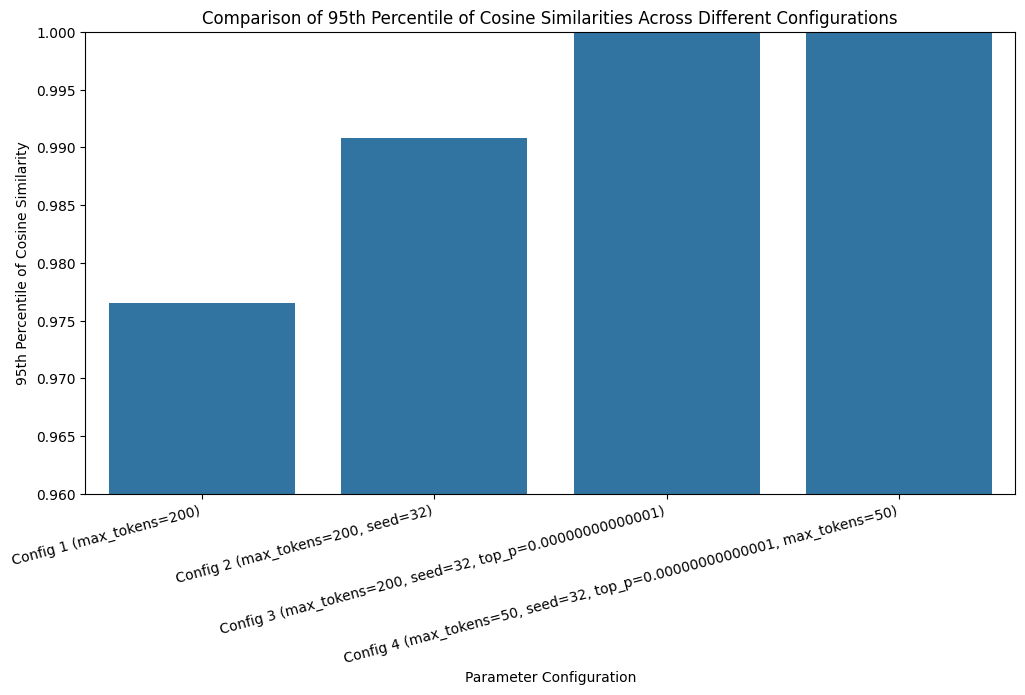

In [35]:
combined_df = pd.concat([noseed_results_df, seed_results_df, seed_lowtopp_results_df, seed_lowtopp_lowtokens_results_df], ignore_index=True)

percentile_95 = combined_df.groupby("Configuration")["Cosine_Similarity"].quantile(0.95).reset_index()

plt.figure(figsize=(12, 6))

sns.barplot(data=percentile_95, x="Configuration", y="Cosine_Similarity")

# Customize plot
plt.xticks(rotation=15, ha="right")  # Rotate x-axis labels for readability
plt.xlabel("Parameter Configuration")
plt.ylabel("95th Percentile of Cosine Similarity")
plt.title("Comparison of 95th Percentile of Cosine Similarities Across Different Configurations")

plt.ylim(0.96, 1.0)

# Show plot
plt.show()